# Training Our PHOG Using RandTransform and pretrained Image Encodings

In [1]:
# Import dependencies
import os
import sys
import json
import random
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader

# Need to add the root directory to the path in order to import source and image_encoder
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root not in sys.path:
    sys.path.append(root)

from rand_transform import rand_transform, get_dsl_operations
import source as source
import image_encoder as encoder

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


In [8]:
class JSONDataset(Dataset):
    def __init__(self, folder_path, only_inputs=True):
        """
        Custom dataset to load in all json files within a target folder.
        Returns a tuple of (key, ARC_Object).
        """
        self.folder_path = os.path.join(root, folder_path)
        self.only_inputs = only_inputs
        self.samples = self.load_samples(self.folder_path)

    def load_samples(self, folder_path):
        samples = []
        viable_keys = ['input'] if self.only_inputs else ['input', 'output']
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.json'):
                file_path = os.path.join(folder_path, file_name)        
                with open(file_path, 'r') as f:
                    data = json.load(f)
                
                # Iterate through 'train' and 'test' keys in the JSON
                file_id = file_name.split('.')[0]
                for split in ['train', 'test']:
                    if split in data:
                        for i, sample in enumerate(data[split]):
                            for key in viable_keys:
                                if key in sample:
                                    image = np.array(sample[key], dtype=int)
                                    arc_object = source.ARC_Object(image)
                                    samples.append((f"{file_id}-{key}-{i}", arc_object))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

class PHOG_ARC_DatasetWrapper(Dataset):
    def __init__(self, dataset, label_operations, rand_transform, elems_per_image=16, max_labels=8):
        self.dataset = dataset
        self.label_operations = {label_operation: i for i, label_operation in enumerate(label_operations)}
        self.elems_per_image = elems_per_image
        self.max_labels = max_labels
        self.rand_transform = rand_transform
        self.sep_token = "<SEP>"
        self.pad_token = "<PAD>"

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        key, image = self.dataset[idx]
        use_base = random.random() < 0.2
        input_objs, transformed_objs, transforms = self.rand_transform(image, use_base=use_base)
        x = input_objs
        x.extend([self.pad_token] * (self.elems_per_image - len(x)) + [self.sep_token])
        x.extend(transformed_objs)
        x.extend([self.pad_token] * ((self.elems_per_image*2 + 1) - len(x)))
        y = list(map(lambda x: self.label_operations[x], transforms))
        y.extend([-1] * (self.max_labels - len(y)))
        return key, x, y
    
class PHOG_ARC_Dataloader(DataLoader):
    def __init__(self, dataset, batch_size=1, shuffle=True):
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=self.collate_fn)

    @staticmethod
    def collate_fn(batch):
        keys, x, y = zip(*batch)
        keys = list(keys)
        x_batch = list(x)
        y_batch = list(y)
        return keys, x_batch, y_batch

In [9]:
train_dataset = JSONDataset("data/training", only_inputs=True)
train_dataset = PHOG_ARC_DatasetWrapper(train_dataset, get_dsl_operations(), rand_transform, elems_per_image=16)
train_loader = PHOG_ARC_Dataloader(train_dataset, batch_size=1, shuffle=True)

(3, 3)


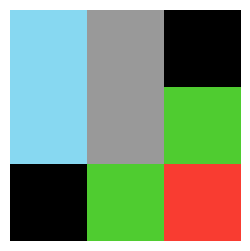

(3, 3)


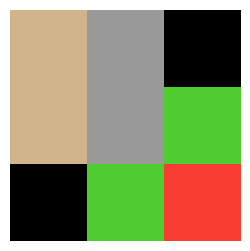

(0, 0)


ValueError: zero-size array to reduction operation minimum which has no identity

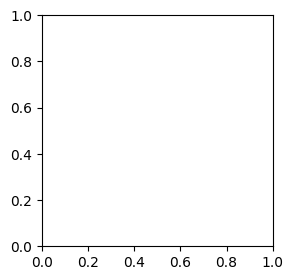

In [ ]:
dsl_operations = get_dsl_operations()
for i, (key, x, y) in enumerate(train_loader):
    # print(f"Key: {key}")
    # print(f"X: {x}")
    # print(f"Y: {y}")
    # print(f"Y: {', '.join([dsl_operations[yi].__name__ if yi >= 0 else '' for yi in y[0]])}")

    for im in x[0]:
        if im == "<PAD>" or im == "<SEP>":
            continue
        print(im.grid.shape)
        # im.plot_grid()